Some weights of BertForQuestionAnswering were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/home/sbhavan/.local/lib/python3.11/site-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1 / 5


Running Evaluation: 100%|██████████| 15875/15875 [02:28<00:00, 107.23it/s]


Train Accuracy: 0.4785, Train Loss: 1.6827, F1 Score: 0.5231, WER Score: 6.3064
Epoch 2 / 5


Running Evaluation: 100%|██████████| 15875/15875 [02:31<00:00, 104.48it/s]


Train Accuracy: 0.6992, Train Loss: 0.7536, F1 Score: 0.6546, WER Score: 4.7183
Epoch 3 / 5


Running Evaluation: 100%|██████████| 15875/15875 [02:31<00:00, 104.67it/s]


Train Accuracy: 0.8050, Train Loss: 0.4255, F1 Score: 0.6156, WER Score: 3.3923
Epoch 4 / 5


Running Evaluation: 100%|██████████| 15875/15875 [02:30<00:00, 105.58it/s]


Train Accuracy: 0.8596, Train Loss: 0.2842, F1 Score: 0.6199, WER Score: 3.2362
Epoch 5 / 5


Running Evaluation: 100%|██████████| 15875/15875 [02:32<00:00, 104.21it/s]


Train Accuracy: 0.8997, Train Loss: 0.1986, F1 Score: 0.6030, WER Score: 3.9002


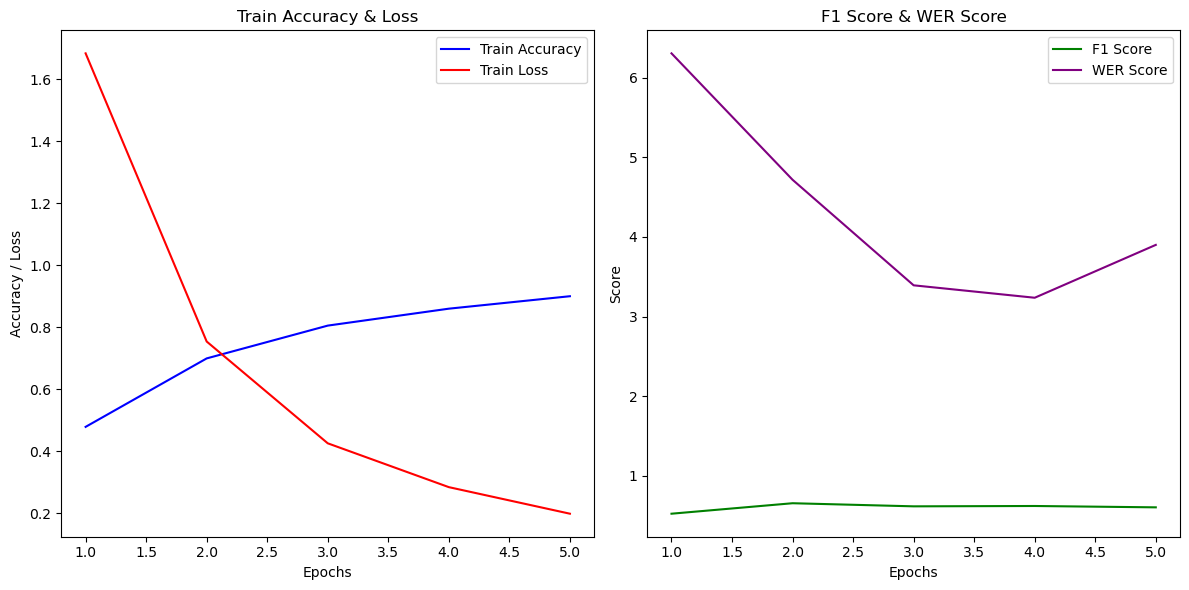

In [2]:
import json
import torch
import torch.nn as nn
import torch.nn.functional as F
from transformers import BertForQuestionAnswering, BertTokenizerFast, AdamW
from torch.utils.data import Dataset, DataLoader
from jiwer import wer
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(f'{device}')
def dataload(dataset): 
    with open(dataset, 'rb') as f:
        raw_data = json.load(f)
    para = []
    questions = []
    answers = []
    for group in raw_data['data']:
        for paragraph in group['paragraphs']:
            context = paragraph['context']
            for qa in paragraph['qas']:
                question = qa['question']
                for answer in qa['answers']:
                    para.append(context.lower())
                    questions.append(question.lower())
                    answers.append(answer)
    return para, questions, answers
train_contexts, train_questions, train_answers = dataload('spoken_train-v1.1.json')
valid_contexts, valid_questions, valid_answers = dataload('spoken_test-v1.1.json')
def end_cal(answers, para):
    for answer, context in zip(answers, para):
        answer['text'] = answer['text'].lower()
        answer['answer_end'] = answer['answer_start'] + len(answer['text'])
end_cal(train_answers, train_contexts)
end_cal(valid_answers, valid_contexts)
Bert_Cap = 512
path = "bert-base-uncased"
doc_stride = 128
tokenizerFast = BertTokenizerFast.from_pretrained(path)
train_contexts_trunc=[]
for i in range(len(train_contexts)):
    if(len(train_contexts[i])>512):
        answer_start=train_answers[i]['answer_start']
        answer_end=train_answers[i]['answer_start']+len(train_answers[i]['text'])
        mid=(answer_start+answer_end)//2
        para_start=max(0,min(mid - Bert_Cap//2,len(train_contexts[i])-Bert_Cap))
        para_end = para_start + Bert_Cap 
        train_contexts_trunc.append(train_contexts[i][para_start:para_end])
        train_answers[i]['answer_start']=((512/2)-len(train_answers[i])//2)
    else:
        train_contexts_trunc.append(train_contexts[i])
train_encodings_fast = tokenizerFast(train_questions, train_contexts_trunc,  max_length = Bert_Cap,truncation=True,
        stride=doc_stride,
        padding=True)
valid_encodings_fast = tokenizerFast(valid_questions,valid_contexts,  max_length = Bert_Cap, truncation=True,stride=doc_stride,
        padding=True)
def train_start_and_end(idx):
    ret_start = 0
    ret_end = 0
    answer_encoding_fast = tokenizerFast(train_answers[idx]['text'],  max_length = Bert_Cap, truncation=True, padding=True)
    for a in range( len(train_encodings_fast['input_ids'][idx]) -  len(answer_encoding_fast['input_ids']) ):
        match = True
        for i in range(1,len(answer_encoding_fast['input_ids']) - 1):
            if (answer_encoding_fast['input_ids'][i] != train_encodings_fast['input_ids'][idx][a + i]):
                match = False
                break
            if match:
                ret_start = a+1
                ret_end = a+i+1
                break
    return(ret_start, ret_end)
start_positions = []
end_positions = []
ctr = 0
for h in range(len(train_encodings_fast['input_ids'])):
    s, e = train_start_and_end(h)
    start_positions.append(s)
    end_positions.append(e)
    if s==0:
        ctr = ctr + 1
train_encodings_fast.update({'start_positions': start_positions, 'end_positions': end_positions})
valid_encodings_fast.update({'start_positions': start_positions, 'end_positions': end_positions})

class InputDataset(Dataset):
    def __init__(self, encodings):
        self.encodings = encodings
    def __getitem__(self, i):
        return {
            'input_ids': torch.tensor(self.encodings['input_ids'][i]),
            'token_type_ids': torch.tensor(self.encodings['token_type_ids'][i]),
            'attention_mask': torch.tensor(self.encodings['attention_mask'][i]),
            'start_positions': torch.tensor(self.encodings['start_positions'][i]),
            'end_positions': torch.tensor(self.encodings['end_positions'][i])
        }
    def __len__(self):
        return len(self.encodings['input_ids'])
train_dataset = InputDataset(train_encodings_fast)
valid_dataset = InputDataset(valid_encodings_fast)
train_data_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
valid_data_loader = DataLoader(valid_dataset, batch_size=1)
bert_model = BertForQuestionAnswering.from_pretrained(path)
class new_model(nn.Module):
    def __init__(self):
        super(new_model, self).__init__()
        self.bert = bert_model
        self.device = device
        self.to(device)
    def forward(self, input_ids, attention_mask, token_type_ids=None):
        model_output = self.bert(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
        return model_output.start_logits, model_output.end_logits
model = new_model()
optim = AdamW(model.parameters(), lr=5e-5, weight_decay=2e-2)
h=120
f1=1*h
def loss_function(start_logits, end_logits, start_positions, end_positions, gamma):
    smax = nn.Softmax(dim=1)
    probs_start = smax(start_logits)
    inv_probs_start = 1 - probs_start
    probs_end = smax(end_logits)
    inv_probs_end = 1 - probs_end
    lsmax = nn.LogSoftmax(dim=1)
    log_probs_start = lsmax(start_logits)
    log_probs_end = lsmax(end_logits)
    nll = nn.NLLLoss()
    fl_start = nll(torch.pow(inv_probs_start, gamma) * log_probs_start, start_positions)
    fl_end = nll(torch.pow(inv_probs_end, gamma) * log_probs_end, end_positions)
    return ((fl_start + fl_end) / 2)
total_acc = []
total_loss = []
f1_scores = []
wer_list = []
from tqdm import tqdm
def train_model(model, dataloader):
    model = model.train()
    losses = []
    acc = []
    for batch in tqdm(dataloader, desc='Running Epoch '):
        optim.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        start_positions = batch['start_positions'].to(device)
        end_positions = batch['end_positions'].to(device)
        out_start, out_end = model(input_ids=input_ids, attention_mask=attention_mask)
        loss = loss_function(out_start, out_end, start_positions, end_positions, 1)
        loss.backward()
        optim.step()
        losses.append(loss.item())
        start_pred = torch.argmax(out_start, dim=1)
        end_pred = torch.argmax(out_end, dim=1)
        acc.append(((start_pred == start_positions).sum()/len(start_pred)).item())
        acc.append(((end_pred == end_positions).sum()/len(end_pred)).item())
    return sum(acc)/len(acc), sum(losses)/len(losses)
def jiwer(model, dataloader):
    model = model.eval()
    answer_list = []
    with torch.no_grad():
        for batch in tqdm(dataloader, desc='Running Evaluation'):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            token_type_ids = batch['token_type_ids'].to(device)
            start_true = batch['start_positions'].to(device)
            end_true = batch['end_positions'].to(device)
            out_start, out_end = model(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
            start_pred = torch.argmax(out_start)
            end_pred = torch.argmax(out_end)
            answer = tokenizerFast.convert_tokens_to_string(tokenizerFast.convert_ids_to_tokens(input_ids[0][start_pred:end_pred]))
            tanswer = tokenizerFast.convert_tokens_to_string(tokenizerFast.convert_ids_to_tokens(input_ids[0][start_true[0]:end_true[0]]))
            answer_list.append([answer,tanswer])
    return answer_list
model.to(device)
for epoch in range(5):
    print(f'Epoch {epoch+1} / 5')
    train_acc, train_loss = train_model(model, train_data_loader)
    answer_list = jiwer(model, valid_data_loader)
    pred_answers = []
    true_answers = []
    for i in range(len(answer_list)):
        pred_answers.append(answer_list[i][0] if len(answer_list[i][0]) > 0 else "$")
        true_answers.append(answer_list[i][1] if len(answer_list[i][1]) > 0 else "$")
    wer_score = wer(true_answers, pred_answers)
    wer_list.append(wer_score)
    f1 = f1*f1_score(true_answers, pred_answers, average='macro') 
    f1_scores.append(f1)
    total_acc.append(train_acc)
    total_loss.append(train_loss)
    print(f'Train Accuracy: {train_acc:.4f}, Train Loss: {train_loss:.4f}, F1 Score: {f1:.4f}, WER Score: {wer_score:.4f}')

epochs = list(range(1, 6))
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs, total_acc, label='Train Accuracy', color='blue')
plt.plot(epochs, total_loss, label='Train Loss', color='red')
plt.xlabel('Epochs')
plt.ylabel('Accuracy / Loss')
plt.title('Train Accuracy & Loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(epochs, f1_scores, label='F1 Score', color='green')
plt.plot(epochs, wer_list, label='WER Score', color='purple')
plt.xlabel('Epochs')
plt.ylabel('Score')
plt.title('F1 Score & WER Score')
plt.legend()
plt.tight_layout()
plt.show()
